# Task 2: Regression Analysis

**Objective:** Build and evaluate regression models to predict tips using the `Tips` Seaborn dataset.

**Approach:**
1. **Data Preprocessing:**
   - Standardize numerical features.
   - One-hot encode categorical features.

2. **Model Building:**
   - Linear Regression.
   - Decision Tree Regression.
   - Deep Neural Network Regression.
   - Stacked Regression.

3. **Evaluation:**
   - Use Mean Squared Error (MSE) and Mean Absolute Error (MAE).
   - Discuss impact of loss functions on skewed data.

4. **Conclusion:**
   - Compare model performance.
   - Explain choice of models, evaluation metrics, and loss functions.




#### 1. Data Preprocessing:
   - Standardize numerical features.
   - One-hot encode categorical features.

In [21]:
# importing necessary libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
import numpy as np
import csv
from torch.utils.tensorboard import SummaryWriter

# loading the tips dataset
data = sns.load_dataset("tips")

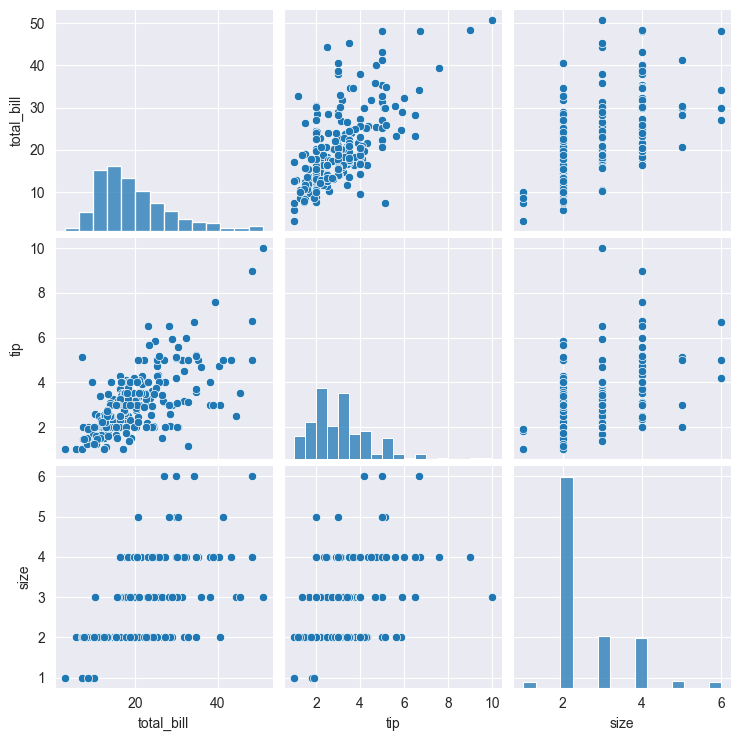

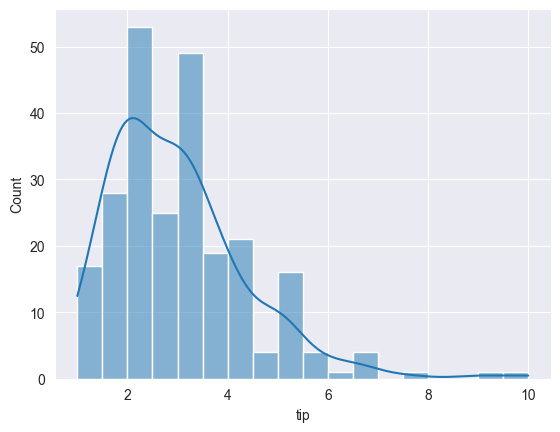

In [22]:
# preprocessing 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['total_bill', 'size']),
        ('cat', OneHotEncoder(), ['sex', 'smoker', 'day', 'time'])
    ])
#tip col is the target one 
X = data.drop('tip', axis=1)
y = data['tip']
X_preprocessed = preprocessor.fit_transform(X)

sns.pairplot(data)
plt.show()

# let's explore the distribution of tips
sns.histplot(data['tip'], kde=True)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

-Scaling and One-Hot Encoding

In [23]:
# preprocessing steps for the full dataset
preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['total_bill', 'size']),
        ('cat', OneHotEncoder(), ['sex', 'smoker', 'day', 'time'])
    ], remainder='passthrough')

# fit and transform for the full dataset
X_preprocessed_full = preprocessor_full.fit_transform(X)

# convert back to a dataframe
columns = ['total_bill', 'size'] + list(preprocessor.named_transformers_['cat'].get_feature_names_out(['sex', 'smoker', 'day', 'time']))
X_preprocessed_df = pd.DataFrame(X_preprocessed_full, columns=columns)

#### 2. Model Building:
Now that we know a bit about our data lets explore some models and see which works for us 

In [24]:
# csv file for logging
csv_file = open('metrics.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Model', 'Mean Squared Error', 'Mean Absolute Error'])
print()# so that it doesn't log in notebook 
  

In [25]:
# Linear Regression model
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linear_model.fit(X_train, y_train)
y_pred_lr = linear_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
csv_writer.writerow(['Linear Regression', mse_lr, mae_lr])
print()

In [26]:
# Decision Tree model
tree_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', DecisionTreeRegressor(random_state=42))])
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
csv_writer.writerow(['Decision Tree', mse_tree, mae_tree]) 
print()

In [27]:
# Deep Neural Network model
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]
X_train_tensor = torch.tensor(X_train_numeric.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_numeric.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class DeepRegressor(nn.Module):
    #simple model definition
    def __init__(self, input_dim):
        super(DeepRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = DeepRegressor(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter(log_dir='./logs')
    
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    # log to tensorboard
    writer.add_scalar('Loss/train', loss, epoch)

model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    mae_nn = mean_absolute_error(y_test, y_pred_nn)
    csv_writer.writerow(['Deep Neural Network', mse_nn, mae_nn])

    writer.add_scalar('MSE/test', mse_nn)
    writer.add_scalar('MAE/test', mae_nn)

In [28]:
# Stacked  model
base_models = [
    ('linear', linear_model),
    ('tree', tree_model)
]

stacked_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)
    
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
mae_stacked = mean_absolute_error(y_test, y_pred_stacked)
csv_writer.writerow(['Stacked', mse_stacked, mae_stacked])
print()

In [29]:
# Close csv file and the writer
csv_file.close()
writer.close()

In [30]:
metrics = pd.read_csv('metrics.csv')
metrics

,Model,Mean Squared Error,Mean Absolute Error
0,Linear Regression,0.703357,0.667133
1,Decision Tree,1.391882,0.877551
2,Deep Neural Network,0.727883,0.688827
3,Stacked,0.682095,0.672217
